In [ ]:
import os
from glob import glob
from imagedaemon import registry
import json
# let's try to run the winter calibration pipeline
from imagedaemon.utils.paths import RAW_DATA_DIR
from imagedaemon.utils.image import Image
from imagedaemon.utils.wcs_utils import pix2sky



available_cameras = registry.available()
print("Registered cameras:", available_cameras)

print_cameras_found = False
if print_cameras_found:
    # check the camera parameters
    for camname in available_cameras:
        camera = registry.get(camname)
        print("camera:")
        for entry in camera.meta:
            print(f"\t {entry}")

PROJECT_ROOT = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon
CONFIG_DIR = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/config
Registered cameras: ['qcmos', 'summer-ccd', 'winter']


Focus images: ['/Users/nlourie/data/image-daemon-data/raw/summer-ccd/focus/SUMMER_20221026_182502_Camera0.fits', '/Users/nlourie/data/image-daemon-data/raw/summer-ccd/focus/SUMMER_20221026_182536_Camera0.fits', '/Users/nlourie/data/image-daemon-data/raw/summer-ccd/focus/SUMMER_20221026_182608_Camera0.fits', '/Users/nlourie/data/image-daemon-data/raw/summer-ccd/focus/SUMMER_20221026_182640_Camera0.fits', '/Users/nlourie/data/image-daemon-data/raw/summer-ccd/focus/SUMMER_20221026_182716_Camera0.fits', '/Users/nlourie/data/image-daemon-data/raw/summer-ccd/focus/SUMMER_20221026_182803_Camera0.fits']
type(focus_images): <class 'list'>
Focus images loaded: {'': [<imagedaemon.utils.image.Image object at 0x2911de7d0>, <imagedaemon.utils.image.Image object at 0x1753d5d10>, <imagedaemon.utils.image.Image object at 0x291452ed0>, <imagedaemon.utils.image.Image object at 0x175404c90>, <imagedaemon.utils.image.Image object at 0x175404e50>, <imagedaemon.utils.image.Image object at 0x17543b250>]}
runn

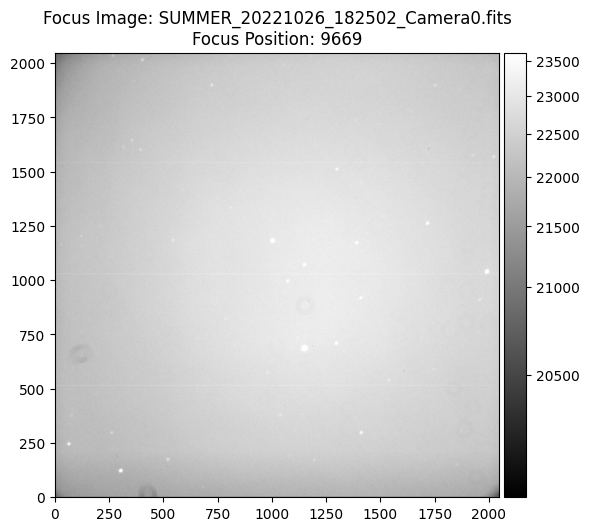

In [4]:
# try to set up the focus
summerccd = registry.get("summer-ccd")

focus_dir = os.path.join(RAW_DATA_DIR, "summer-ccd", "focus")
focus_images = sorted(glob(os.path.join(focus_dir, "*.fits")))

# plot one
img = Image(focus_images[0])
img.plot_image(title = f"Focus Image: {img.filename}\nFocus Position: {img.header['FOCPOS']:.0f}",)


print(f"Focus images: {focus_images}")
print(f"type(focus_images): {type(focus_images)}")
res = summerccd._load_focus_images(focus_images)
print(f"Focus images loaded: {res}")
# calibrate all the focus images
focus_calibrated = summerccd.calibrate_for_focus(
    image_paths = focus_images,
    out_dir = os.path.join(os.getenv("HOME"), "data", "tmp"),
)

print(f"Focus calibrated images: {focus_calibrated}")

# now try for a focus loop

results = summerccd.run_focus_loop(image_list = focus_images,
                                   addrs = None,
                                   output_dir = None)

print(f"Focus loop results: {results}")

# plot the first one
#focus_calibrated[0].plot_image(f"First Focus Calibrated Image: {focus_calibrated[0].filename}",)



Science image: /Users/nlourie/data/image-daemon-data/raw/summer-ccd/focus/SUMMER_20221026_182502_Camera0.fits


[I imagedaemon.pipeline] Calibration started | camera=summer-ccd image=/Users/nlourie/data/image-daemon-data/raw/summer-ccd/focus/SUMMER_20221026_182502_Camera0.fits


running _calibrate_data with addr=None
[DEBUG][None] raw: finite=4196352/4196352, min=1, max=4.77e+04
[DEBUG][None] after hot pixel mask: finite=4196352/4196352, min=1, max=4.77e+04
[DEBUG][None] after NaN replacement: finite=4196352/4196352, min=1, max=4.77e+04


[I imagedaemon.pipeline] Calibration started | camera=summer-ccd image=/Users/nlourie/data/image-daemon-data/raw/summer-ccd/focus/SUMMER_20221026_182502_Camera0.fits


running _calibrate_data with addr=None
[DEBUG][None] raw: finite=4196352/4196352, min=1, max=4.77e+04
[DEBUG][None] after hot pixel mask: finite=4196352/4196352, min=1, max=4.77e+04
[DEBUG][None] after NaN replacement: finite=4196352/4196352, min=1, max=4.77e+04
[astrometry] solve-field /Users/nlourie/data/tmp/SUMMER_20221026_182502_Camera0.cal.fits --scale-units arcsecperpix --scale-low 0.4427 --scale-high 0.48930000000000007 --ra 302.18827340521665 --dec 44.09489823548611 --radius 2.0 --downsample 2 --overwrite --no-plots --cpulimit 30 

Reading input file 1 of 1: "/Users/nlourie/data/tmp/SUMMER_20221026_182502_Camera0.cal.fits"...
Running command: /opt/homebrew/bin/image2pnm --infile /Users/nlourie/data/tmp/SUMMER_20221026_182502_Camera0.cal.fits --uncompressed-outfile /tmp/tmp.uncompressed.zKelQs --outfile /tmp/tmp.ppm.m9wSJP --ppm --mydir /opt/homebrew/bin/solve-field
Extracting sources...
Downsampling by 2...
simplexy: found 449 sources.
Solving...
fitsbin.c:449:read_chunk: Could

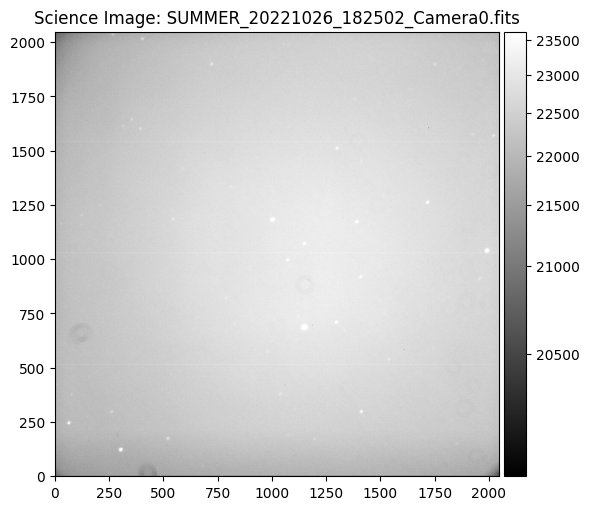

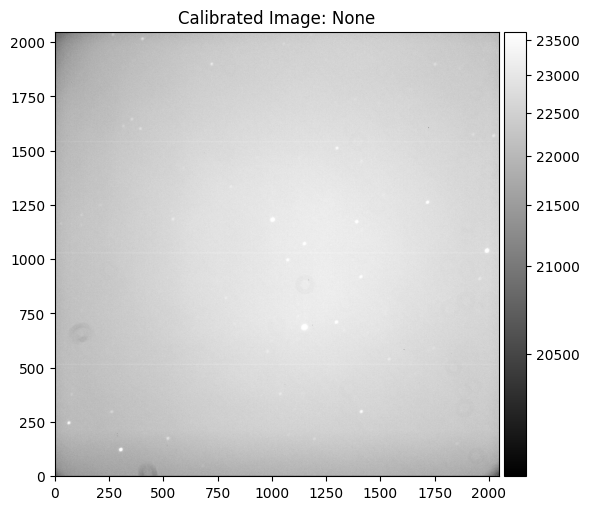

In [3]:
# now run astrometry on a summer-ccd image

# try again with a full summer-ccd image
summerccd = registry.get("summer-ccd")

image_dir = os.path.join(RAW_DATA_DIR, "summer-ccd", "focus")
science_images = sorted(glob(os.path.join(image_dir, "*.fits")))
science_image = science_images[0]
print(f"Science image: {science_image}")

# plot the image just for fun
image = Image(science_image)
image.plot_image(title = f"Science Image: {image.filename}",)

# run the full astrometric pipeline
output_dir = os.path.join(os.path.join(os.getenv("HOME"), "data", "tmp"))

# background images
background_images = science_images


# this image has no RA/Dec in the header, so we need to set it
ra_guess = None
dec_guess = None

# calibrate the image
calimg = summerccd.calibrate_image(science_image = science_image, 
                                 background_image_list = background_images)

# try to save the calibrated image
# plot the image
calimg.plot_image(title = f"Calibrated Image: {calimg.filename}",)

info = summerccd.get_astrometric_solution(science_image = science_image,
                                      background_image_list = None,
                                      output_dir = output_dir,
                                      ra = None,
                                      dec = None,
    )
wcs = info["wcs"]
# the image is 4096 x 2304
wx = 2048
wy = 2049
# let's try to get the WCS for a pixel in the center of the image
x_pix, y_pix = wx // 2, wy // 2
sky_pos = pix2sky(x_pix, y_pix, wcs)
print(
    f"Coord conversion: (x, y) = ({x_pix}, {y_pix}) -> (RA, Dec) = ({sky_pos.ra:.1f}, {sky_pos.dec:.1f}) deg"
)